In [1]:
import numpy as np
import matplotlib.pyplot as plt

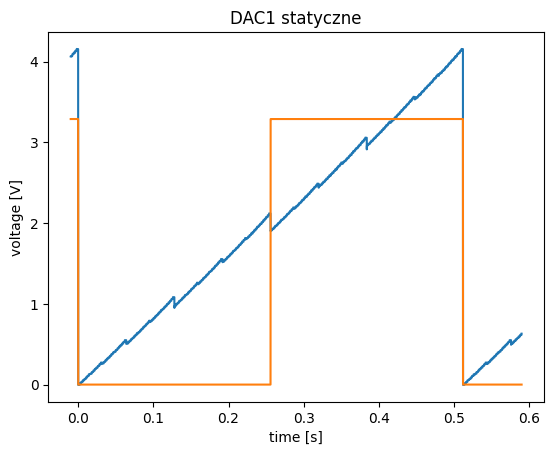

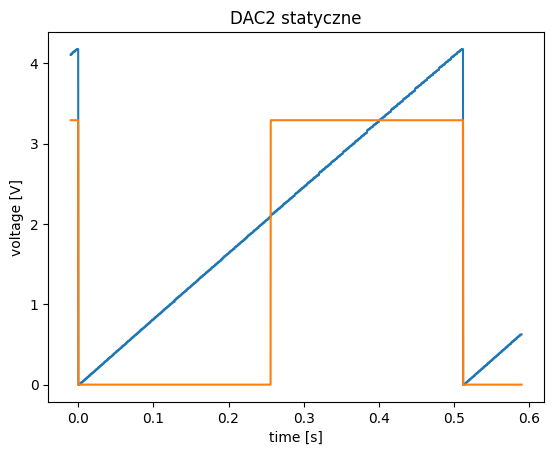

In [3]:
DAC1_statyczne = np.loadtxt('dane\DAC1_statyczne.csv', delimiter=',', skiprows=11)
DAC2_statyczne = np.loadtxt('dane\DAC2_statyczne.csv', delimiter=',', skiprows=11)
plt.figure()
plt.plot(DAC1_statyczne[:,0], DAC1_statyczne[:,1])
plt.plot(DAC1_statyczne[:,0], DAC1_statyczne[:,2])
plt.title('DAC1 statyczne')
plt.xlabel('time [s]')
plt.ylabel('voltage [V]')
plt.show()
plt.figure()
plt.plot(DAC2_statyczne[:,0], DAC2_statyczne[:,1])
plt.plot(DAC2_statyczne[:,0], DAC2_statyczne[:,2])
plt.title('DAC2 statyczne')
plt.xlabel('time [s]')
plt.ylabel('voltage [V]')
plt.show()

In [15]:
def analyze_static_DAC(data, DAC_name):
    data_full = data
    output_full = data_full[:, 1]
    trigger_full = data_full[:, 2]

    start_threshold = 1.5  # V
    start_index = np.where(trigger_full < start_threshold)[0][0]

    end_threshold = 1.5  # V
    end_index = np.where(trigger_full > end_threshold)[0][-1]

    # Step 3: Slice the data (remove redundant data on both sides)
    data = data_full[start_index:end_index]
    print(data)
    time = data[:, 0] - data[0, 0]
    output = data[:, 1]
    trigger = data[:, 2]

    # Step 4: DAC resolution
    N = 8
    num_codes = 2**N

    # Step 5: Map time to input codes (ramping from max code to 0)
    code = np.round((num_codes - 1) - (time - time[0]) / (time[-1] - time[0]) * (num_codes - 1)).astype(int)

    # Step 6: Group outputs by code and compute average
    outputs_per_code = [[] for _ in range(num_codes)]
    for i in range(len(code)):
        if 0 <= code[i] < num_codes:
            outputs_per_code[code[i]].append(output[i])
    measured = np.array([np.mean(vals) if vals else np.nan for vals in outputs_per_code])

    # Step 7: Valid indices and ideal
    valid_indices = ~np.isnan(measured)
    Vmin = np.min(measured[valid_indices])
    Vmax = np.max(measured[valid_indices])
    ideal = Vmin + (Vmax - Vmin) * np.arange(num_codes) / (num_codes - 1)

    # Step 8: Calculate LSB and DNL/INL
    LSB = (Vmax - Vmin) / (num_codes - 1)
    DNL = np.diff(measured[valid_indices]) / LSB - 1
    INL = np.cumsum(DNL)

    # Additional calculations
    full_range = Vmax - Vmin  # Pełny zakres napięcia wyjściowego
    gain = LSB  # Współczynnik skalowania (wzmocnienie) Vout od słowa bitowego

    # Offset error (przesunięcie zera)
    offset_error = measured[0] - Vmin if not np.isnan(measured[0]) else np.nan

    # Gain error (błąd wzmocnienia): Fit linear regression to measured data
    from scipy.stats import linregress
    codes_valid = np.arange(num_codes)[valid_indices]
    slope, intercept, _, _, _ = linregress(codes_valid, measured[valid_indices])
    gain_measured = slope
    gain_error_percent = (gain_measured - gain) / gain * 100 if gain != 0 else np.nan

    # Print the values
    print(f"{DAC_name} - LSB: {LSB:.6f} V")
    print(f"{DAC_name} - Pełny zakres napięcia wyjściowego: {full_range:.6f} V")
    print(f"{DAC_name} - Współczynnik skalowania (wzmocnienie): {gain:.6f} V/bit")
    print(f"{DAC_name} - Błąd wzmocnienia: {gain_error_percent:.2f} %")
    print(f"{DAC_name} - Przesunięcie zera (offset): {offset_error:.6f} V")
    # Optional: Plot the results
    plt.figure()
    plt.plot(np.arange(num_codes)[valid_indices], measured[valid_indices], label='Measured')
    plt.plot(np.arange(num_codes), ideal, label='Ideal')
    plt.xlabel('Code')
    plt.ylabel('Output Voltage (V)')
    plt.title(f'{DAC_name} Static Characteristic')
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(np.arange(len(DNL)), DNL, label='DNL')
    plt.plot(np.arange(len(INL)), INL, label='INL')
    plt.xlabel('Code')
    plt.ylabel('Non-Linearity')
    plt.title(f'{DAC_name} DNL and INL')
    plt.legend()
    plt.show()

[[ 4.47960167e-05 -2.78361385e-03  1.38837394e-03]
 [ 1.18046017e-04 -1.76802335e-03  1.73015382e-03]
 [ 1.91296017e-04 -1.76802335e-03  1.73015382e-03]
 ...
 [ 5.11769296e-01  4.15673655e+00  3.29033617e+00]
 [ 5.11842546e-01  4.15673655e+00  3.28999439e+00]
 [ 5.11915796e-01  4.15673655e+00  3.29033617e+00]]
DAC1 - LSB: 0.016308 V
DAC1 - Pełny zakres napięcia wyjściowego: 4.158480 V
DAC1 - Współczynnik skalowania (wzmocnienie): 0.016308 V/bit
DAC1 - Błąd wzmocnienia: -196.97 %
DAC1 - Przesunięcie zera (offset): 4.158480 V


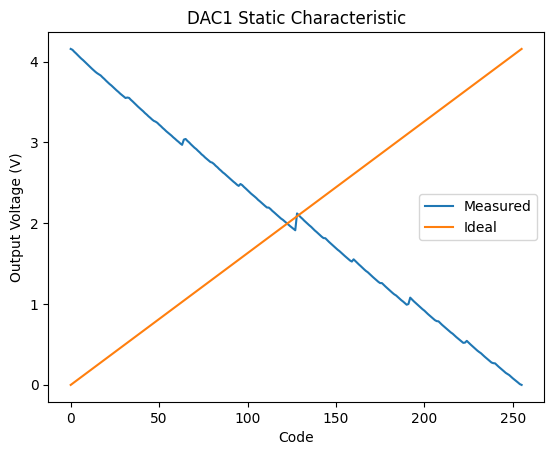

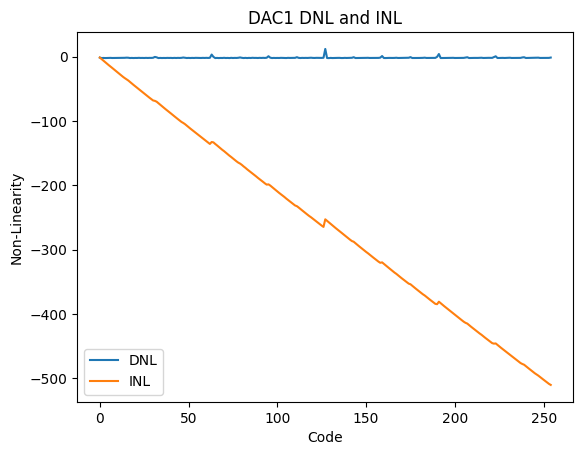

[[ 1.48533468e-05  1.45255757e+00  9.39232368e-01]
 [ 8.81033468e-05 -1.76802335e-03  1.73015382e-03]
 [ 1.61353347e-04 -1.76802335e-03  1.38837394e-03]
 ...
 [ 5.11739353e-01  4.17467865e+00  3.28999439e+00]
 [ 5.11812603e-01  4.17467865e+00  3.29033617e+00]
 [ 5.11885853e-01  4.17467865e+00  3.28999439e+00]]
DAC2 - LSB: 0.016345 V
DAC2 - Pełny zakres napięcia wyjściowego: 4.167983 V
DAC2 - Współczynnik skalowania (wzmocnienie): 0.016345 V/bit
DAC2 - Błąd wzmocnienia: -200.71 %
DAC2 - Przesunięcie zera (offset): 4.167983 V


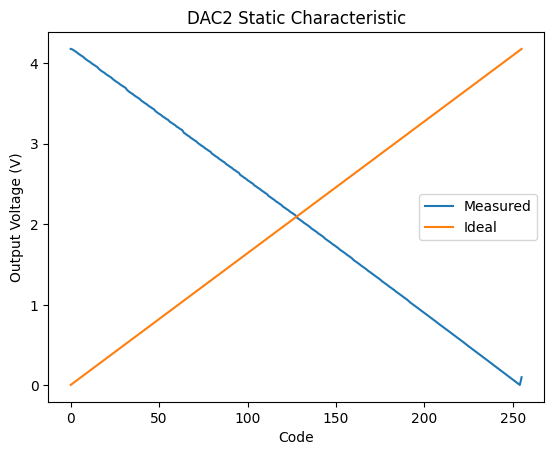

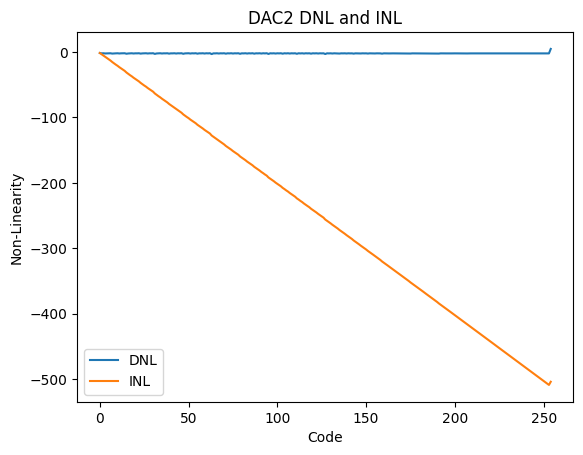

In [16]:
analyze_static_DAC(DAC1_statyczne, 'DAC1')
analyze_static_DAC(DAC2_statyczne, 'DAC2')